In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import xgboost as xgb
import scipy

shap.initjs()

In [2]:
dataIdx = 1
dataDir = "./ihdp_csv_1-1000/csv/"
dataFileName = "ihdp_npci_{}.csv".format(dataIdx)
data = pd.read_csv(dataDir+dataFileName, header=None)

In [3]:
header = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + ["x{}".format(i) for i in range(1, 26)]
data.columns = header
data

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,0,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,...,1,0,1,0,0,0,0,0,0,0
743,1,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,0.808706,...,1,1,1,0,0,0,0,0,0,0
744,0,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,0.746189,...,1,1,1,0,0,0,0,0,0,0
745,0,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,...,1,1,1,0,0,0,0,0,0,0


## Imbalance Features

X01: 0.082450
X02: 0.333258
X03: 0.100459
X04: 0.160733
X05: 0.128753
X06: 0.163631
X07: 0.006827
X08: 0.012818
X09: 0.270202
X10: 0.132666
X11: 0.030021
X12: 0.006459
X13: 0.039141
X14: 0.195217
X15: 0.005773
X16: 0.042722
X17: 0.167272
X18: 0.050302
X19: 0.027577
X20: 0.122425
X21: 0.027862
X22: 0.079386
X23: 0.102930


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


X24: 0.123295
X25: 0.200539


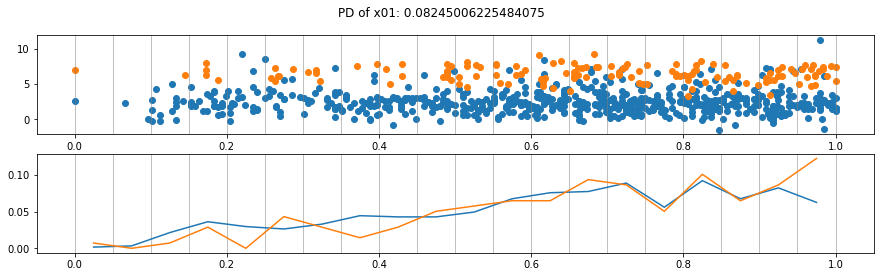

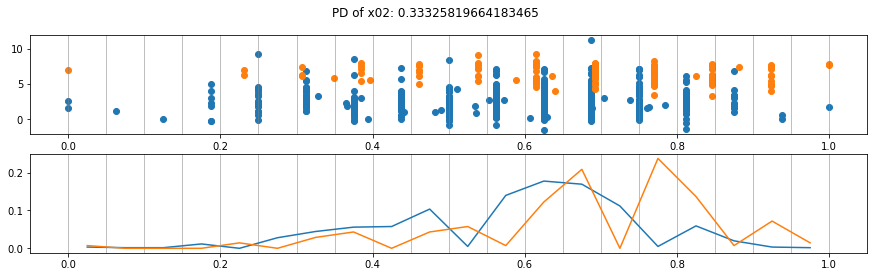

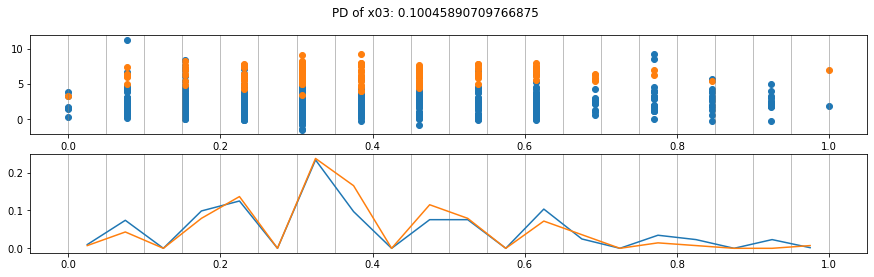

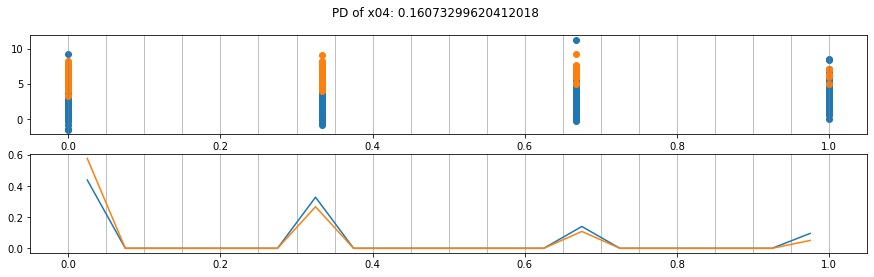

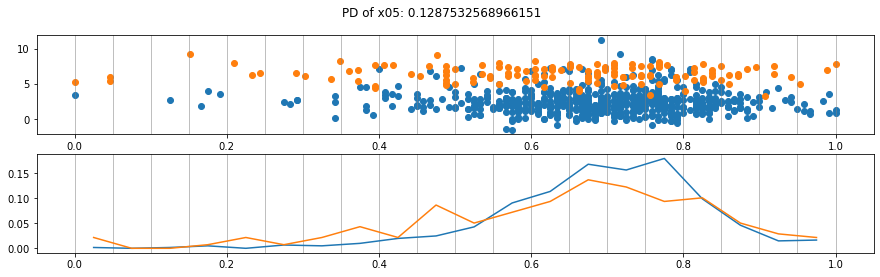

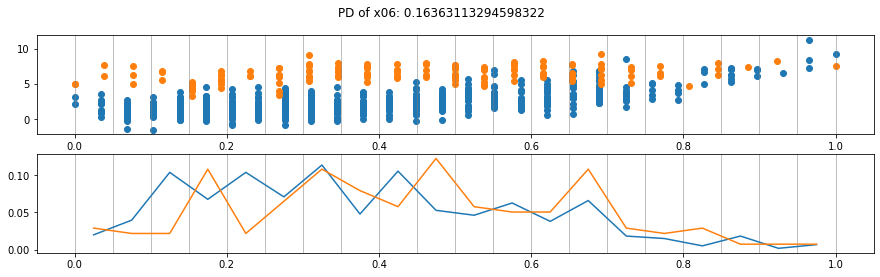

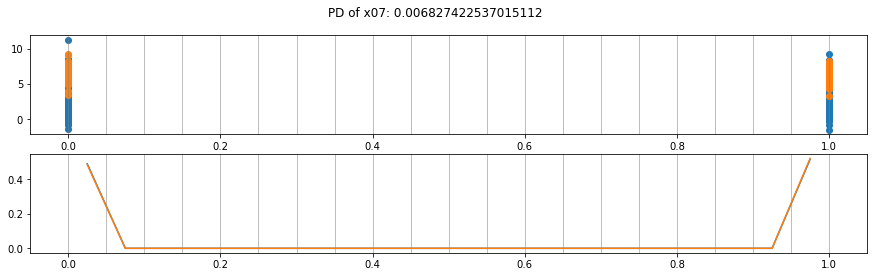

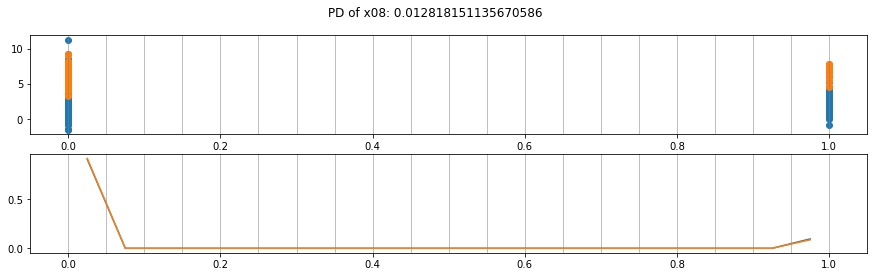

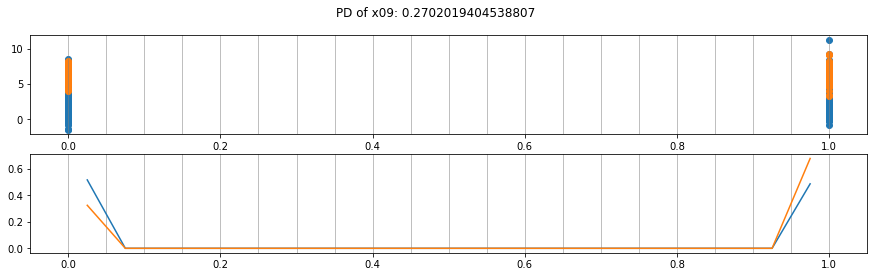

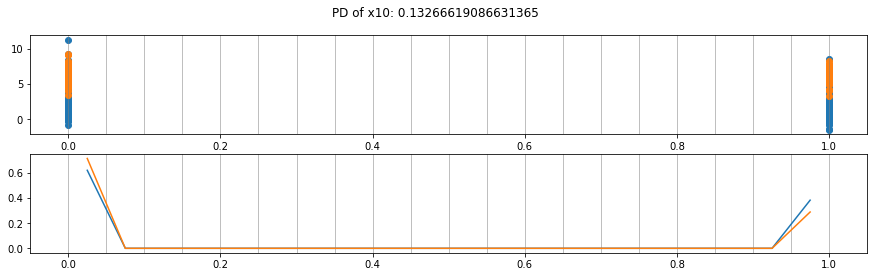

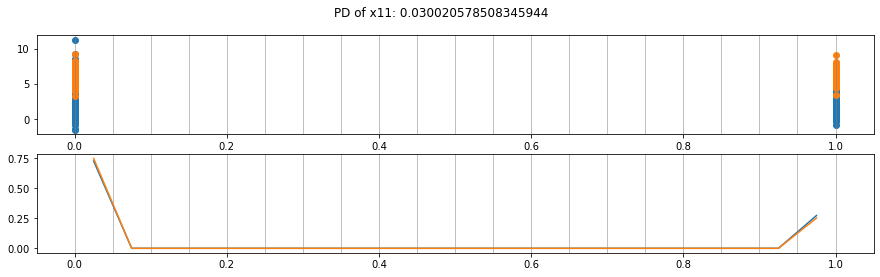

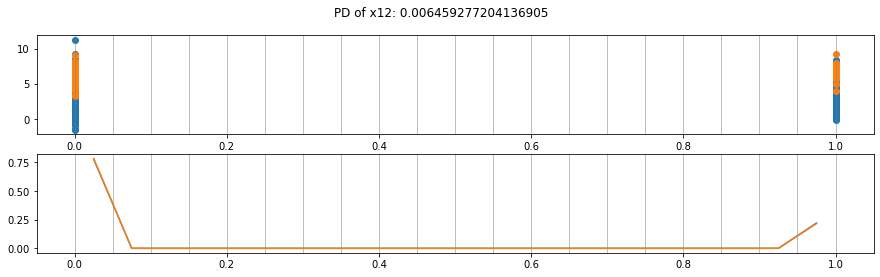

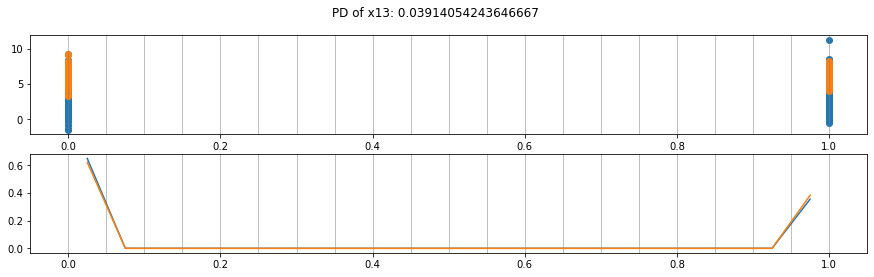

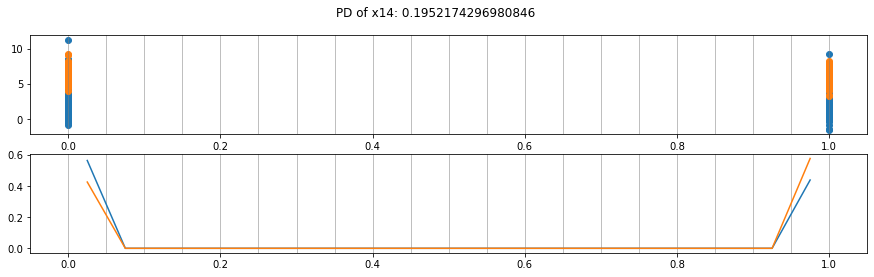

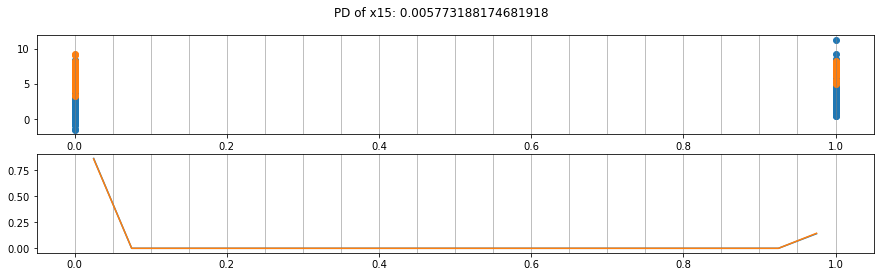

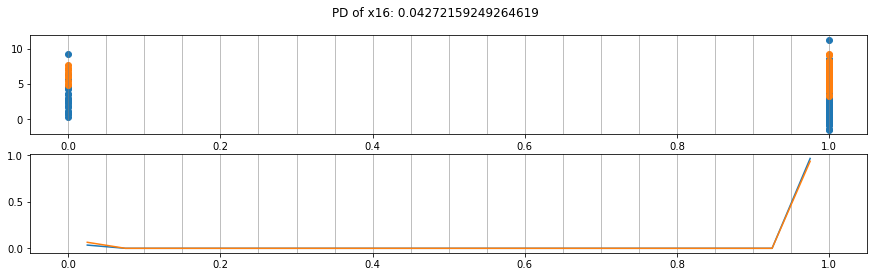

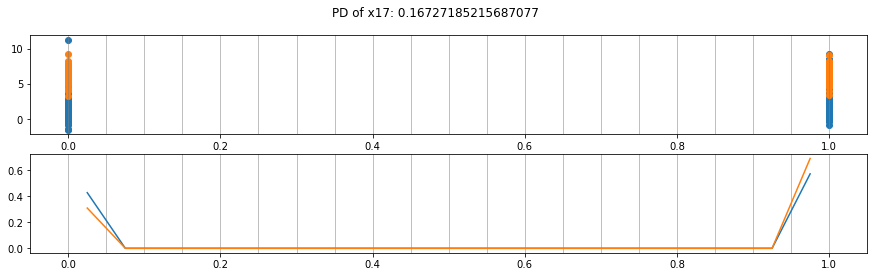

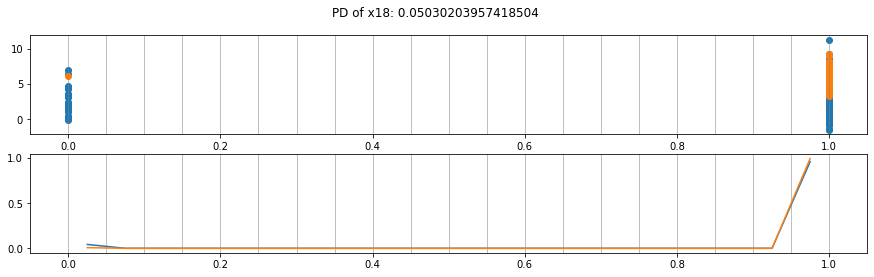

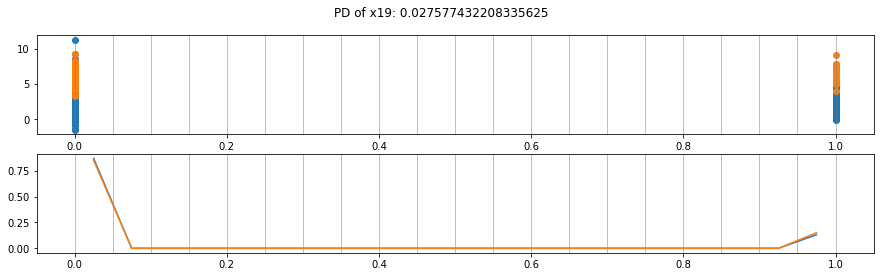

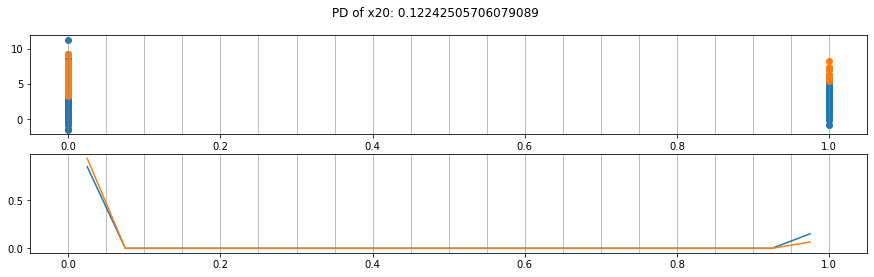

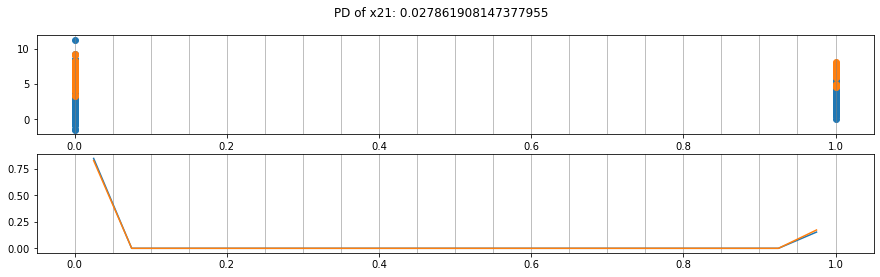

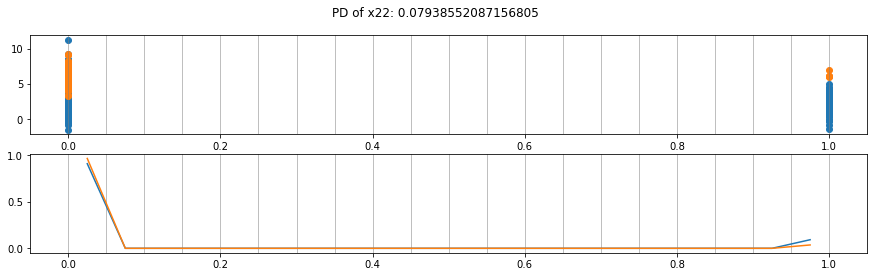

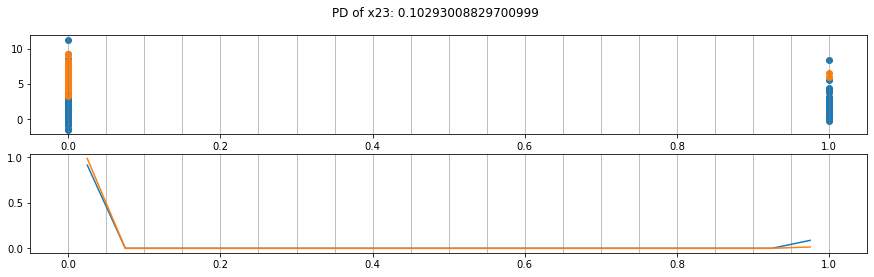

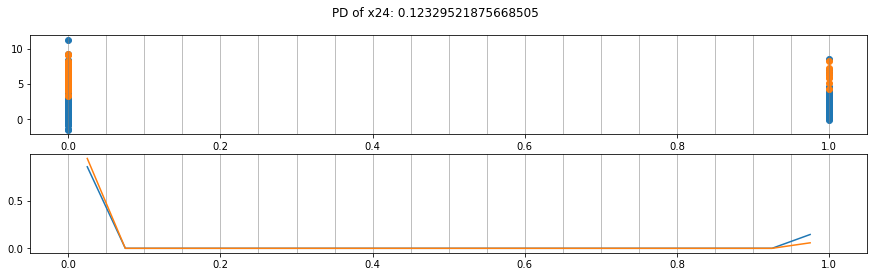

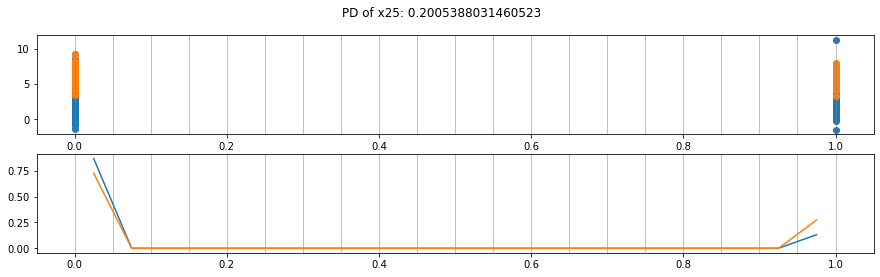

In [4]:
t = data["treatment"]
t0Y = data["y_factual"][t==0]
t1Y = data["y_factual"][t==1]
probDiff = np.zeros(25)
normalOutcome = (t1Y - np.min(t1Y)) / (np.max(t1Y) - np.min(t1Y))
bins = np.arange(0, 1.05, 0.05)
t0Probs = np.zeros(shape=(25, len(bins)-1))
t1Probs = np.zeros(shape=(25, len(bins)-1))

for i in range(1, 26):
    t0X = data["x{}".format(i)][t==0]
    t1X = data["x{}".format(i)][t==1]
    normt1X = (t1X - np.min(t1X)) / (np.max(t1X) - np.min(t1X))
    t1Prob, interval = np.histogram(normt1X, bins=bins, density=False)
    t1Prob = t1Prob/np.sum(t1Prob)
    t1Probs[i-1, :] = t1Prob
    normt0X = (t0X - np.min(t0X)) / (np.max(t0X) - np.min(t0X))
    t0Prob, interval = np.histogram(normt0X, bins=bins, density=False)
    t0Prob = t0Prob/np.sum(t0Prob)
    t0Probs[i-1, :] = t0Prob
    probDiff[i-1] = np.sqrt(np.sum((t1Prob-t0Prob)**2))
    fig, ax = plt.subplots(2, 1, figsize=(15, 4))
    fig.suptitle("PD of x{:02d}: {}".format(i, probDiff[i-1]))
    for j in bins:
        ax[0].axvline(j, color='gray', linewidth=0.5)
        ax[1].axvline(j, color='gray', linewidth=0.5)

    ax[0].scatter(normt0X, t0Y)
    ax[0].scatter(normt1X, t1Y)
    ax[1].plot((bins[:-1]+bins[1:])/2, t0Prob)
    ax[1].plot((bins[:-1]+bins[1:])/2, t1Prob)
    print("X{:02d}: {:05f}".format(i, probDiff[i-1]))

    

In [5]:
t1CumuProb = np.zeros(t1Probs.shape)
t1CumuProb[:, 0] = t1Probs[:, 0]
t0CumuProb = np.zeros(t0Probs.shape)
t0CumuProb[:, 0] = t0Probs[:, 0]

for i in range(1, 20):
    t1CumuProb[:, i] = t1CumuProb[:, i-1] + t1Probs[:, i]
    t0CumuProb[:, i] = t0CumuProb[:, i-1] + t0Probs[:, i]

In [6]:
for i in range(25):
    print("X{:02d}".format(i+1), np.sum(np.abs(t0CumuProb[i, :] - t1CumuProb[i, :])))

X01 0.9656380159030669
X02 2.050312381673608
X03 0.7457994131010973
X04 1.636915467625899
X05 1.2285119273002651
X06 1.2795460999621358
X07 0.09172661870503623
X08 0.17221223021582788
X09 3.6301708633093517
X10 1.782374100719424
X11 0.4033273381294964
X12 0.08678057553956942
X13 0.5258543165467628
X14 2.6227517985611506
X15 0.07756294964028809
X16 0.5739658273381293
X17 2.2473021582733805
X18 0.6758093525179857
X19 0.37050359712230185
X20 1.6447841726618688
X21 0.3743255395683457
X22 1.0665467625899272
X23 1.3828687050359711
X24 1.6564748201438855
X25 2.6942446043165464


shannonEntropy = np.zeros(25)
for i in range(1, 26):
    #print("x{}".format(i))
    #print("{} / {}".format(len(np.unique(data["x{}".format(i)])), len(data["x{}".format(i)])))
    uniqueX, counts = np.unique(data["x{}".format(i)], return_counts=True)
    
    pi = counts/len(data["treatment"])
    H = - np.sum(pi * np.log(pi))
    print("===== X{:02d} =====".format(i))
    print("{:02f} / {:02f} = {:02f}".format(H, np.log(len(uniqueX)), H / np.log(len(uniqueX))))
    shannonEntropy[i-1] = H / np.log(len(uniqueX))
    
    #print(scipy.stats.skew(data["x{}".format(i)][data["treatment"]==1]))
    #print(scipy.stats.skew(data["x{}".format(i)][data["treatment"]==0]))

In [7]:
print(probDiff)

[0.08245006 0.3332582  0.10045891 0.160733   0.12875326 0.16363113
 0.00682742 0.01281815 0.27020194 0.13266619 0.03002058 0.00645928
 0.03914054 0.19521743 0.00577319 0.04272159 0.16727185 0.05030204
 0.02757743 0.12242506 0.02786191 0.07938552 0.10293009 0.12329522
 0.2005388 ]


In [8]:
def getSequence(targetArray):
    ta = targetArray.copy()
    orderCandicate = np.arange(len(ta)) + 1
    order = []
    while np.max(ta) != 0:
        maxValue = np.max(ta)
        maxOrder = orderCandicate[ta == maxValue]
        order.append(maxOrder[0])
        ta[maxOrder-1] = 0
    return order
#print(shannonEntropy)
#order = getSequence(shannonEntropy)
#for i, j in zip(order, [shannonEntropy[x-1] for x in order]):
#    print("{:02d} / {:02f}".format(i, j))
    
print(probDiff)
order = getSequence(probDiff)
for i, j in zip(order, [probDiff[x-1] for x in order]):
    print("{:02d} / {:02f}".format(i, j))

[0.08245006 0.3332582  0.10045891 0.160733   0.12875326 0.16363113
 0.00682742 0.01281815 0.27020194 0.13266619 0.03002058 0.00645928
 0.03914054 0.19521743 0.00577319 0.04272159 0.16727185 0.05030204
 0.02757743 0.12242506 0.02786191 0.07938552 0.10293009 0.12329522
 0.2005388 ]
02 / 0.333258
09 / 0.270202
25 / 0.200539
14 / 0.195217
17 / 0.167272
06 / 0.163631
04 / 0.160733
10 / 0.132666
05 / 0.128753
24 / 0.123295
20 / 0.122425
23 / 0.102930
03 / 0.100459
01 / 0.082450
22 / 0.079386
18 / 0.050302
16 / 0.042722
13 / 0.039141
11 / 0.030021
21 / 0.027862
19 / 0.027577
08 / 0.012818
07 / 0.006827
12 / 0.006459
15 / 0.005773


## XGBoost and SHAP values

In [9]:
X = data['treatment']
X = pd.concat((X, data.iloc[:, 5:]), axis=1)
arrX = np.array(X)
normX = np.zeros(arrX.shape)
for i in range(arrX.shape[1]):
    normX[:, i] = (arrX[:, i] - np.min(arrX[:, i])) / (np.max(arrX[:, i]) - np.min(arrX[:, i]))
y = data['y_factual']
yCF = data['y_cfactual']

In [10]:
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10)
model.fit(arrX, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(arrX, tree_limit=-1)

In [12]:
#Get model predictions
y_pred = model.predict(arrX)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

Model prediction: 5.600175857543945
Mean prediction + interaction values: 5.600176811218262


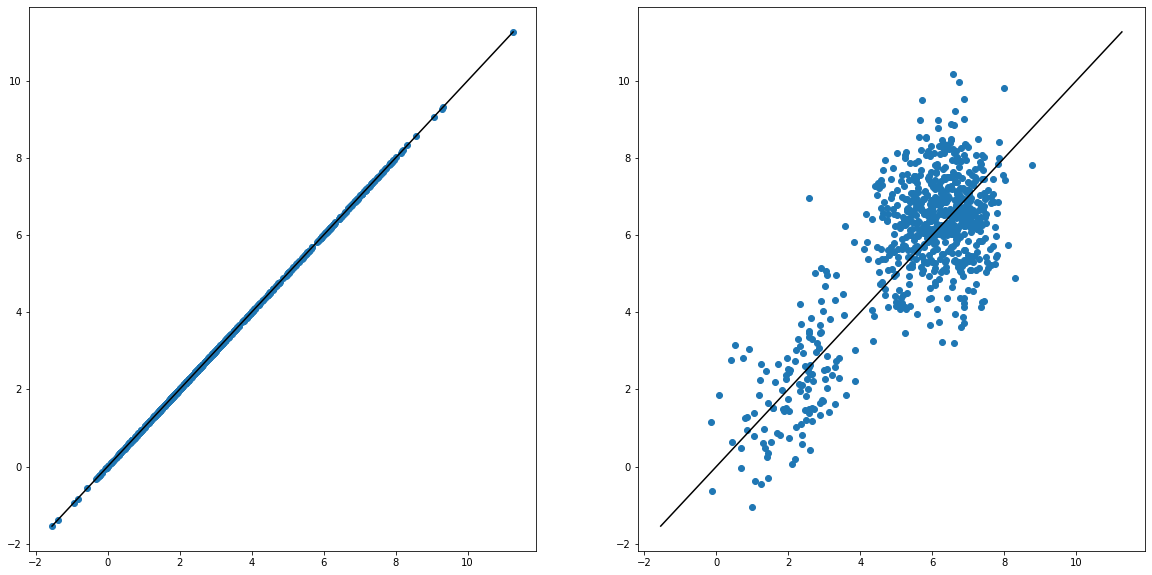

In [13]:
y_pred = model.predict(arrX)
cfX = X.copy()
cfX.iloc[:, 0] = 1 - cfX.iloc[:, 0]
ycf_pred = model.predict(np.array(cfX))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(y_pred, y)
axs[1].scatter(ycf_pred, data["y_cfactual"])
axs[0].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='black')
axs[1].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='black')

In [35]:
class Evaluator(object):
    def __init__(self, y, t, y_cf=None, mu0=None, mu1=None):
        self.y = y
        self.t = t
        self.y_cf = y_cf
        self.mu0 = mu0
        self.mu1 = mu1
        if mu0 is not None and mu1 is not None:
            self.true_ite = mu1 - mu0

    def rmse_ite(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == 0)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return np.sqrt(np.mean(np.square(self.true_ite - pred_ite)))

    def abs_ate(self, ypred1, ypred0):
        return np.abs(np.mean(ypred1 - ypred0) - np.mean(self.true_ite))

    def pehe(self, ypred1, ypred0):
        return np.sqrt(np.mean(np.square((self.mu1 - self.mu0) - (ypred1 - ypred0))))

    def getPredITE(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == 0)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return pred_ite

In [15]:
xt0 = X.copy()
xt0["treatment"] = 0
xt1 = X.copy()
xt1["treatment"] = 1
ypred0 = model.predict(np.array(xt0))
ypred1 = model.predict(np.array(xt1))

In [16]:
eva = Evaluator(y=np.array(data["y_factual"]), 
                t=np.array(data["treatment"]), 
                y_cf=np.array(data["y_cfactual"]), 
                mu0=np.array(data["mu0"]), 
                mu1=np.array(data["mu1"]))
print(eva.rmse_ite(ypred1=ypred1, ypred0=ypred0))
print(eva.abs_ate(ypred1=ypred1, ypred0=ypred0))
print(eva.pehe(ypred1=ypred1, ypred0=ypred0))

1.1654761625864969
0.18755303541582347
1.1650791734091825


## Retrain Model with X02 >=< 0.75

In [19]:
y = data["y_factual"]
normalX2 = (data["x2"] - np.min(data["x2"])) / (np.max(data["x2"]) - np.min(data["x2"]))
threshold = 0.75

In [20]:
Xsmall = data['treatment'][normalX2 <= threshold]
Xsmall = pd.concat((Xsmall, data.iloc[:, 5:][normalX2 <= threshold]), axis=1)
arrXsmall = np.array(Xsmall)
normXsmall = np.zeros(arrXsmall.shape)
for i in range(arrXsmall.shape[1]):
    normXsmall[:, i] = (arrXsmall[:, i] - np.min(arrXsmall[:, i])) / (np.max(arrXsmall[:, i]) - np.min(arrXsmall[:, i]))
ySmall = data['y_factual'][normalX2 <= threshold]
yCFsmall = data['y_cfactual'][normalX2 <= threshold]

In [21]:
modelSmall = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10)
modelSmall.fit(arrXsmall, ySmall)
y_predSmall = modelSmall.predict(arrXsmall)
cfXsmall = Xsmall.copy()
cfXsmall.iloc[:, 0] = 1 - cfXsmall.iloc[:, 0]
ycf_predSmall = modelSmall.predict(np.array(cfXsmall))

In [22]:
Xlarge = data['treatment'][normalX2 > threshold]
Xlarge = pd.concat((Xlarge, data.iloc[:, 5:][normalX2 > threshold]), axis=1)
arrXlarge = np.array(Xlarge)
normXlarge = np.zeros(arrXlarge.shape)
for i in range(arrXlarge.shape[1]):
    normXlarge[:, i] = (arrXlarge[:, i] - np.min(arrXlarge[:, i])) / (np.max(arrXlarge[:, i]) - np.min(arrXlarge[:, i]))
yLarge = data['y_factual'][normalX2 > threshold]
yCFlarge = data['y_cfactual'][normalX2 > threshold]

In [23]:
modelLarge = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10)
modelLarge.fit(arrXlarge, yLarge)
y_predLarge = modelLarge.predict(arrXlarge)
cfXlarge = Xlarge.copy()
cfXlarge.iloc[:, 0] = 1 - cfXlarge.iloc[:, 0]
ycf_predLarge = modelLarge.predict(np.array(cfXlarge))

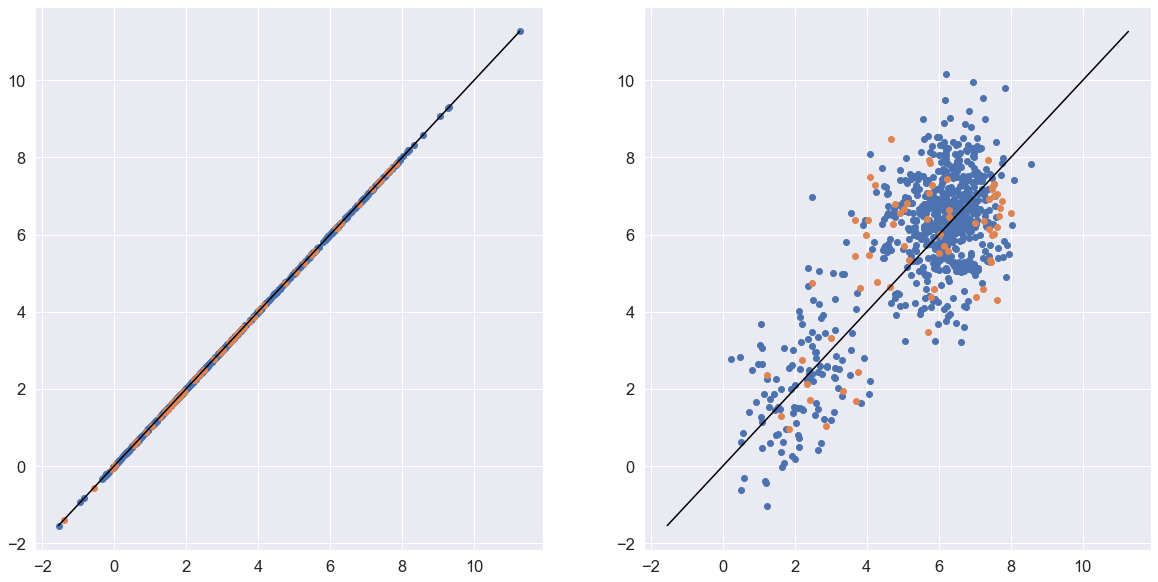

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(y_predSmall, y[normalX2 < threshold])
axs[0].scatter(y_predLarge, y[normalX2 > threshold])
axs[1].scatter(ycf_predSmall, yCFsmall)
axs[1].scatter(ycf_predLarge, yCFlarge)
axs[0].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='black')
axs[1].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='black')

In [25]:
xt0 = Xsmall.copy()
xt0["treatment"] = 0
xt1 = Xsmall.copy()
xt1["treatment"] = 1
ypred0small = modelSmall.predict(np.array(xt0))
ypred1small = modelSmall.predict(np.array(xt1))

In [26]:
xt0 = Xlarge.copy()
xt0["treatment"] = 0
xt1 = Xlarge.copy()
xt1["treatment"] = 1
ypred0large = modelLarge.predict(np.array(xt0))
ypred1large = modelLarge.predict(np.array(xt1))

In [27]:
ypred0 = np.hstack((ypred0small, ypred0large))
ypred1 = np.hstack((ypred1small, ypred1large))

In [40]:
evaSmall = Evaluator(y=np.array(data["y_factual"][normalX2 <= threshold]),
                     t=np.array(data["treatment"][normalX2 <= threshold]),
                     y_cf=np.array(data["y_cfactual"][normalX2 <= threshold]),
                     mu0=np.array(data["mu0"][normalX2 <= threshold]),
                     mu1=np.array(data["mu1"][normalX2 <= threshold]))
print(evaSmall.rmse_ite(ypred1=ypred1small, ypred0=ypred0small))
print(evaSmall.abs_ate(ypred1=ypred1small, ypred0=ypred0small))
print(evaSmall.pehe(ypred1=ypred1small, ypred0=ypred0small))

1.1383201842341937
0.19583366074930275
1.1379922810229104


In [41]:
evaLarge = Evaluator(y=np.array(data["y_factual"][normalX2 > threshold]),
                     t=np.array(data["treatment"][normalX2 > threshold]),
                     y_cf=np.array(data["y_cfactual"][normalX2 > threshold]),
                     mu0=np.array(data["mu0"][normalX2 > threshold]),
                     mu1=np.array(data["mu1"][normalX2 > threshold]))
print(evaLarge.rmse_ite(ypred1=ypred1large, ypred0=ypred0large))
print(evaLarge.abs_ate(ypred1=ypred1large, ypred0=ypred0large))
print(evaLarge.pehe(ypred1=ypred1large, ypred0=ypred0large))

1.4460487206293597
0.31583230941714024
1.445789357750535


[-2.1, 5.0, -4.0, 8.0, -2.1, 5.0, -4.0, 8.0, -2.1, 5.0, -4.0, 8.0]

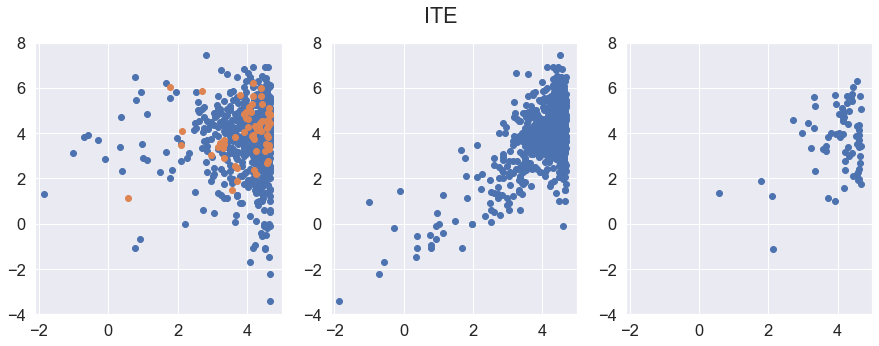

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter((data["mu1"] - data["mu0"])[normalX2 <= threshold], eva.getPredITE(ypred1=ypred1, ypred0=ypred0)[normalX2 <= threshold])
axs[0].scatter((data["mu1"] - data["mu0"])[normalX2 > threshold], eva.getPredITE(ypred1=ypred1, ypred0=ypred0)[normalX2 > threshold])
axs[1].scatter((data["mu1"] - data["mu0"])[normalX2 <= threshold], evaSmall.getPredITE(ypred1=ypred1small, ypred0=ypred0small))
axs[2].scatter((data["mu1"] - data["mu0"])[normalX2 > threshold], evaLarge.getPredITE(ypred1=ypred1large, ypred0=ypred0large))
plt.suptitle("ITE")
plt.setp(axs, xlim=(-2.1, 5), ylim=(-4, 8))

[-3.0, 6.0, -4.0, 8.0, -3.0, 6.0, -4.0, 8.0, -3.0, 6.0, -4.0, 8.0]

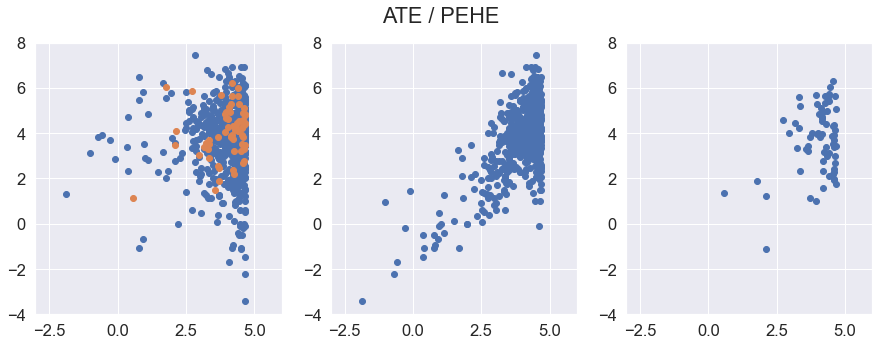

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter((data["mu1"] - data["mu0"])[normalX2 <= threshold], (ypred1 - ypred0)[normalX2 <= threshold])
axs[0].scatter((data["mu1"] - data["mu0"])[normalX2 > threshold], (ypred1 - ypred0)[normalX2 > threshold])
axs[1].scatter((data["mu1"] - data["mu0"])[normalX2 <= threshold], (ypred1small - ypred0small))
axs[2].scatter((data["mu1"] - data["mu0"])[normalX2 > threshold], (ypred1large - ypred0large))
plt.suptitle("ATE / PEHE")
plt.setp(axs, xlim=(-3, 6), ylim=(-4, 8))